# INF6422E – Advanced Concepts in Computer Security  
## Practical Work 1 – Winter 2026  

### Intrusion Detection System and Its Evaluation

--- 
  
## Students  
- Antoine Khoueiry – *Matricule:* 2487137  
- Louis – *Matricule:* XXXXXXX  

---

## Objective

The objective of this practical work is to design, evaluate, and compare classical machine learning–based Intrusion Detection Systems (IDS) using a standard cybersecurity dataset.  
The focus is on quantitative performance evaluation, analysis of trade-offs between detection accuracy and false alarms, and discussion of real-world deployment constraints of IDS solutions.

---

## Dataset

This study uses the **CICIDS2017** dataset, combining:
- **Monday traffic** (Benign baseline)
- **Wednesday traffic** (Benign + DoS + Heartbleed)

---

## Notebook Structure

1. Dataset Analysis and Preprocessing  
2. Classical Machine Learning Models for IDS  
3. Ensemble-Based IDS and Performance Trade-offs 
4. Comparative Performance Analysis


# 1. Dataset Analysis and Preprocessing

## Dataset Construction (Monday + Wednesday)

- **Monday-WorkingHours.pcap_ISCX**: contains only benign (normal) traffic and serves as a baseline.
- **Wednesday-workingHours.pcap_ISCX**: contains a mixture of benign traffic and multiple attack types: DoS and Heartbleed.

The following steps load the raw CSV files and merge them into a single dataset.


In [2]:
import pandas as pd
import numpy as np

# Paths to CICIDS2017 CSV files
monday_path = "MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv"  
wednesday_path = "MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv"

# Load datasets
df_monday = pd.read_csv(monday_path)
df_wednesday = pd.read_csv(wednesday_path)

print("Monday dataset shape:", df_monday.shape)
print("Wednesday dataset shape:", df_wednesday.shape)


# Ensure both datasets have identical columns
assert list(df_monday.columns) == list(df_wednesday.columns), \
    "Column mismatch between Monday and Wednesday datasets"

print("Column structure verified: identical columns")


# Merge datasets
df = pd.concat([df_monday, df_wednesday], axis=0, ignore_index=True)

# Clean column names
df.columns = df.columns.str.strip()

print("Merged dataset shape:", df.shape)



Monday dataset shape: (529918, 79)
Wednesday dataset shape: (692703, 79)
Column structure verified: identical columns
Merged dataset shape: (1222621, 79)


## 1.1 Dataset Exploration

This section presents a statistical exploration of the constructed dataset combining Monday (benign baseline) and Wednesday (benign and attack traffic) from the CICIDS2017 dataset.

The analysis focuses on:
- the total number of samples,
- the number of features,
- the distribution of benign versus attack traffic.

In [3]:
# Number of samples and features
num_samples, num_features = df.shape

print("Total number of samples:", num_samples)
print("Total number of features:", num_features)

Total number of samples: 1222621
Total number of features: 79


In [4]:
# Distribution of traffic labels
label_distribution = df["Label"].value_counts()

print(label_distribution)

Label
BENIGN              969949
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [5]:
# Benign vs Attack distribution
df["BinaryLabel"] = df["Label"].apply(lambda x: "Benign" if x == "BENIGN" else "Attack")

binary_distribution = df["BinaryLabel"].value_counts()
print(binary_distribution)

BinaryLabel
Benign    969949
Attack    252672
Name: count, dtype: int64


### Statistical Summary and Relevance for IDS Evaluation

The constructed dataset contains **1,222,621 network traffic samples** described by **79 features**, providing a high-dimensional representation of network behavior. The dataset combines a clean benign baseline on Monday with attack traffic collected on Wednesday.

The traffic distribution reveals a strong class imbalance. Benign traffic represents **969,949 samples**, while attack traffic accounts for **252,672 samples**. Among malicious activities, **DoS attacks dominate**, particularly *DoS Hulk* (231,073 samples), while other attack types such as *GoldenEye*, *Slowloris*, *Slowhttptest*, and *Heartbleed* appear much less frequently, with Heartbleed being extremely rare (11 samples).

These characteristics are highly relevant for Intrusion Detection System (IDS) evaluation. The class imbalance reflects real-world network conditions, where malicious traffic is significantly rarer than normal traffic. However, such imbalance can bias learning algorithms toward the benign class, potentially increasing false negatives. Additionally, the presence of multiple attack types with varying frequencies challenges IDS models to generalize across both high-volume and low-frequency attacks. As a result, evaluation metrics beyond accuracy, such as precision, recall, and false alarm rate, become critical for assessing IDS effectiveness.


## 1.2 Dataset Preprocessing

This section describes the preprocessing steps applied to the dataset prior to training machine learning models.

The preprocessing pipeline includes:
- cleaning,
- encoding of categorical features,
- feature standardization,
- splitting the dataset into training, validation, and test sets.

In [6]:
'''Cleaning'''

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (1220887, 80)


Some features contained infinite values due to zero-duration flows. These values were replaced with NaN and the corresponding samples were removed to ensure numerical stability during model training.
We also see the number of columns added 1. It's "BinaryLabel" column added at the end of question 1.1.

In [7]:
# Separate features and labels
X = df.drop(columns=["Label", "BinaryLabel"])
y = df["BinaryLabel"]

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (1220887, 78)
Labels shape: (1220887,)


In [8]:
'''Categorical Feature Encoding'''

# Check if there are categorical (non-numeric) features
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Non-numeric feature columns:", non_numeric_cols)
print("Number of non-numeric feature columns:", len(non_numeric_cols))


Non-numeric feature columns: []
Number of non-numeric feature columns: 0


The CICIDS2017 feature set is composed of numerical traffic statistics. We verified the data types of the input features and found no non-numeric (categorical) feature columns. Therefore, no categorical encoding (e.g., one-hot encoding) was required. The `Label` column is treated as the target variable and was handled separately from the feature matrix.

In [9]:
'''Feature standardization'''

from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Although Logistic Regression can operate with both normalization and standardization, standardization was chosen in this work as it provides better numerical stability and robustness to outliers, which are common in network traffic features.


In [10]:
'''Splitting the dataset into training, validation, and test sets'''

from sklearn.model_selection import train_test_split

# Train split (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 854620
Validation set size: 183133
Test set size: 183134


### Split Strategy Justification

The dataset is split into 70% training, 15% validation, and 15% test sets. The training set is used to learn model parameters, while the validation set supports model selection and hyperparameter tuning without biasing the final evaluation. The test set remains unseen during training and provides an unbiased estimate of real-world IDS performance.

'*Stratified*' splitting is applied to preserve the original class distribution across all subsets. This is particularly important in intrusion detection contexts, where class imbalance is common and improper splitting could lead to misleading performance estimates or overfitting.


## 2. Classical Machine Learning Models for IDS

### 2.1 Logistic Regression for Intrusion Detection

In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# Train the model
log_reg.fit(X_train, y_train)




,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
# Predictions
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Evaluation on test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label="Attack")
recall = recall_score(y_test, y_test_pred, pos_label="Attack")
f1 = f1_score(y_test, y_test_pred, pos_label="Attack")

# AUC-ROC (requires probabilities)
y_test_proba = log_reg.predict_proba(X_test)[:, 1]
auc = roc_auc_score((y_test == "Attack").astype(int), y_test_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


Accuracy:  0.9838
Precision: 0.9404
Recall:    0.9840
F1-score:  0.9617
AUC-ROC:   0.0022


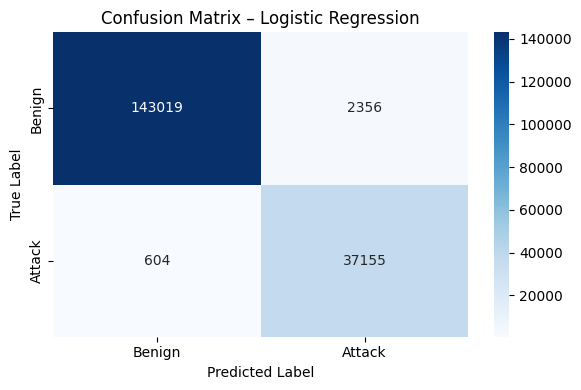

In [16]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred, labels=["Benign", "Attack"])

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Attack"],
    yticklabels=["Benign", "Attack"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()



### Confusion Matrix Interpretation and IDS Implications

The confusion matrix highlights the trade-off between false positives(2356) and false negatives(604) in intrusion detection. False positives correspond to benign traffic incorrectly classified as attacks, which may lead to alert fatigue and unnecessary investigation costs. False negatives represent undetected attacks, which pose a more critical risk as malicious activity may remain unnoticed.

Logistic Regression provides a simple and interpretable baseline IDS model. While it performs well in detecting high-volume attack patterns, its linear decision boundary may limit its ability to capture more complex or low-frequency attack behaviors, motivating the use of ensemble-based methods in the following sections.


## 3. Ensemble-Based IDS Model: Random Forest